<a href="https://colab.research.google.com/github/amanikonda123/CookbookWizard.ai/blob/main/part2_d2v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC 480-F23 NLP and Word2Vec/Doc2Vec🍔:  



https://jalammar.github.io/illustrated-word2vec/

Cool article i found


## Version history

- Version 1: November 12, 2023
  - First Draft of Tutorial

# Authors:


***Ethan Schnepp***

***Randall Caler***

***Aditya Manikonda***

***Thomas Panyasrivinit***




# Copyright: Apache 2.0 License



```
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

```


## Colab and Jupyter Notebooks


In [ ]:
print("Hello World")

Hello World


A Colab consists of a Jupyter notebook that is set up in the cloud. Jupyter notebooks (and thus Colabs) are composed of text cells (like this one) and code cells. An example of a code cell is below; it is marked by two square brackets '[ ]', which turn into an arrow when you move the cursor over them. Clicking on the arrow "runs" the cell: the code contained in the cell is executed. If the code produces an output, it is displayed underneath. There may be a number enclosed between the two brackets. This indicates that the code has been run multiple times.

## Google Account
You need to have a Google account that lets you store files on GDrive. If you have a Gmail account, you should be able to go to [Google Drive](https://drive.google.com/) and log in with your Gmail login and password.




## Create Your Copy
If you want to use and modify a lab, you need to save a copy. To do so, go to the 'File' menu, select 'Save a copy in Drive' and change the name (it begins with 'Copy of ...'). You can share Colab notebooks with others, similar to sharing a document on Google Drive.


## Set Up a Colab
Colabs run in the cloud through your Web browser. There's no need to install software on your computer. A Colab may require other software (libraries) to run, but this is done in the Colab itself, usually at the beginning.  

# Overview

We will be looking at a technique for natural language processing (NLP) called word embeddings. We will first be examining Word2vec, which is a neural network model that learns word asociations from a large corpus of text. Once the model is trained, it can detect synonymous words and levels of semantic similarity. It does this by representing each distinct word with a vector.

We will also be going over Doc2Vec. Doc2Vec is an extension of Word2Vec, and is a paragraph vector that enables the representation of documents as vectors. While Word2Vec is used to learn word embenings, Doc2Vec is used to learn document embeddings. This technique allows us to compare documents based on their vector representation and perform various tasks such as document classification, clustering, and similarity analysis.

By the end of this tutorial, users will have a functional word embeddings model that takes in a general food category and output 10 of the most similar recipes to that food category from a given dataset.



## Prerequisites

Participants should have intermediate background knowledge of Python, a very rudimentary foundation on AI methods, and a Kaggle account to access the datasets.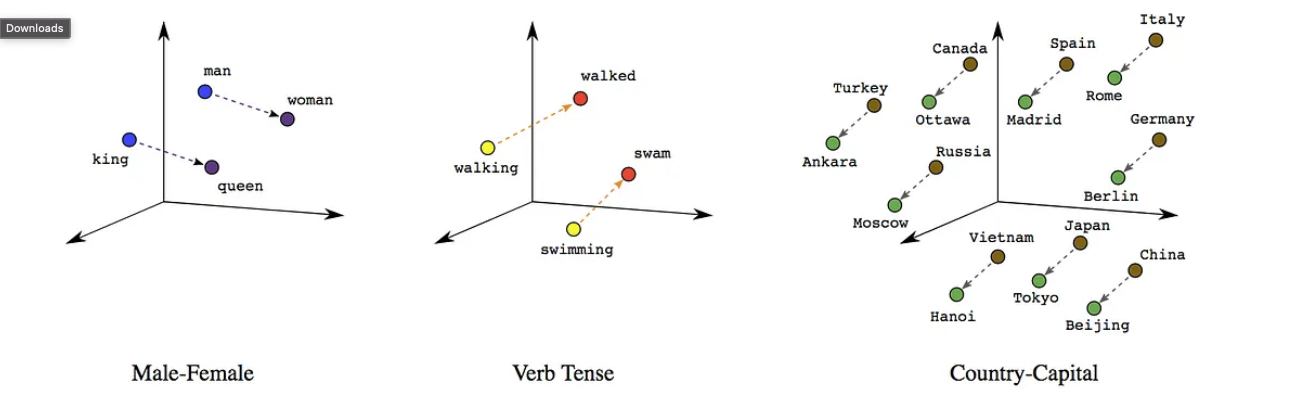

##Learning Objectives

Throughout the tutorial, participants will:

* Have a stronger understanding on what word embeddings can do
* Develop a stronger intuition on when to use Word2Vec or Doc2Vec
* Understand how Word2Vec and Doc2Vec models are trained and what each of their hyperparameters control
* Examine different variations of Word2Vec models such as CBOW and Skip Gram
* Learn how to use the Kaggle API to download datasets from the web



# Imports

Before we get started, let's import all the necessary libraries and models for this tutorial.

In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
!pip install --upgrade gensim

# Data Set


The dataset we will be using can be found on Kaggle and is titled “Food Ingredients and Recipes Dataset with Images” (https://www.kaggle.com/datasets/pes12017000148/food-ingredients-and-recipe-dataset-with-images).

## Data Preparation

Let's load in our dataset. It is important to note that you need a Kaggle account with your username and API token in order to access and download the dataset for our code. To create a new API token, you will have to navigate to the 'Settings' page and click on the 'Create New Token' button under 'API.' This should download a 'kaggle.json' file in which you can see your username and API key.

To load in our datasets, we are using 'opendatasets,' which is a Python library that contains useful functions for downloading datasets from the web (i.e. Kaggle). Once we have our data loaded locally, we can read in the data using the 'read_csv' function in Pandas.

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download(
    "https://www.kaggle.com/datasets/pes12017000148/food-ingredients-and-recipe-dataset-with-images")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: thomaspanyasrivinit1
Your Kaggle Key: ··········


100%|██████████| 206M/206M [00:02<00:00, 104MB/s]


In [ ]:
df_recipes = pd.read_csv("/content/food-ingredients-and-recipe-dataset-with-images/Food Ingredients and Recipe Dataset with Image Name Mapping.csv")

### Exploration of the Data

Our dataset contains two relevant subfolders that correspond to all 13,582 recipes in the dataset. The first subfolder consists of a list of .jpg files that represent images of the recipes while the second subfolder contains all the recipe information in 5 columns: the recipe title, ingredients, instructions, a cleaned up version of the ingredients data, and the name to its corresponding image file from the first subfolder. All of the following data, except for the uncleaned ingredients column, would be relevant for our project because we can use word embeddings on the recipe titles and once we extract the most similar recipes to our target category, we can use all the other fields to reconstruct and present the recipe in a nice manner.

### Preprocessing

Now that we have our data, it would be good to clean it up a little bit. The data is already clean, but there are a few things we could do, such as removing unnecessary columns and rows with missing values.

In [ ]:
# Removes Columns containing indices and cleaned ingredients
df_recipes = df_recipes.drop(['Unnamed: 0', 'Cleaned_Ingredients'], axis=1)

# Removes any rows with missing values
df_recipes.dropna(inplace = True)

# Cleans up Image_Name
df_recipes['Cleaned_Image_Name'] = df_recipes['Image_Name'].str.replace(r'-\d+$', '', regex=True).str.replace("-", " ").str.title()
df_recipes

,Title,Ingredients,Instructions,Image_Name,Cleaned_Image_Name
0,Miso-Butter Roast Chicken With Acorn Squash Pa...,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...","Pat chicken dry with paper towels, season all ...",miso-butter-roast-chicken-acorn-squash-panzanella,Miso Butter Roast Chicken Acorn Squash Panzanella
1,Crispy Salt and Pepper Potatoes,"['2 large egg whites', '1 pound new potatoes (...",Preheat oven to 400°F and line a rimmed baking...,crispy-salt-and-pepper-potatoes-dan-kluger,Crispy Salt And Pepper Potatoes Dan Kluger
2,Thanksgiving Mac and Cheese,"['1 cup evaporated milk', '1 cup whole milk', ...",Place a rack in middle of oven; preheat to 400...,thanksgiving-mac-and-cheese-erick-williams,Thanksgiving Mac And Cheese Erick Williams
3,Italian Sausage and Bread Stuffing,"['1 (¾- to 1-pound) round Italian loaf, cut in...",Preheat oven to 350°F with rack in middle. Gen...,italian-sausage-and-bread-stuffing-240559,Italian Sausage And Bread Stuffing
4,Newton's Law,"['1 teaspoon dark brown sugar', '1 teaspoon ho...",Stir together brown sugar and hot water in a c...,newtons-law-apple-bourbon-cocktail,Newtons Law Apple Bourbon Cocktail
...,...,...,...,...,...
13496,Brownie Pudding Cake,"['1 cup all-purpose flour', '2/3 cup unsweeten...",Preheat the oven to 350°F. Into a bowl sift to...,brownie-pudding-cake-14408,Brownie Pudding Cake
13497,Israeli Couscous with Roasted Butternut Squash...,"['1 preserved lemon', '1 1/2 pound butternut s...",Preheat oven to 475°F.\nHalve lemons and scoop...,israeli-couscous-with-roasted-butternut-squash...,Israeli Couscous With Roasted Butternut Squash...
13498,Rice with Soy-Glazed Bonito Flakes and Sesame ...,['Leftover katsuo bushi (dried bonito flakes) ...,"If using katsuo bushi flakes from package, moi...",rice-with-soy-glazed-bonito-flakes-and-sesame-...,Rice With Soy Glazed Bonito Flakes And Sesame ...
13499,Spanakopita,['1 stick (1/2 cup) plus 1 tablespoon unsalted...,Melt 1 tablespoon butter in a 12-inch heavy sk...,spanakopita-107344,Spanakopita


# Model

## Model Selection

Let's quickly take a look at what Word2Vec does. Word2Vec is a popular word embedding technique in natural language processing (NLP) that aims to represent words from a corpus in a continuous vector space. The primary goal of Word2Vec is to capture semantic and syntactic relationships between words, allowing words with similar meanings or contexts to have similar vector representations.

Word Embedding techniques such as Word2Vec certainly have a lot of use cases including:

* Sentiment Analysis: Helps in determining the sentiment (positive, negative, neutral) of a given text by understanding the contextual meaning of words.
* Language Translation: Aids in translating words and phrases from one language to another by finding equivalent words with similar vector representations.
* Topic Discovery and Modeling: Facilitates the identification and grouping of similar topics within large text corpora by analyzing the distribution of word vectors.
* Chatbot and Virtual Assistant Tr![Screenshot 2023-12-01 at 8.35.16 PM.png]()aining: Enhances the ability of chatbots and virtual assistants to understand and respond to user queries by analyzing the semantic meaning of words in conversations.


Let's visualize how it works with an example.

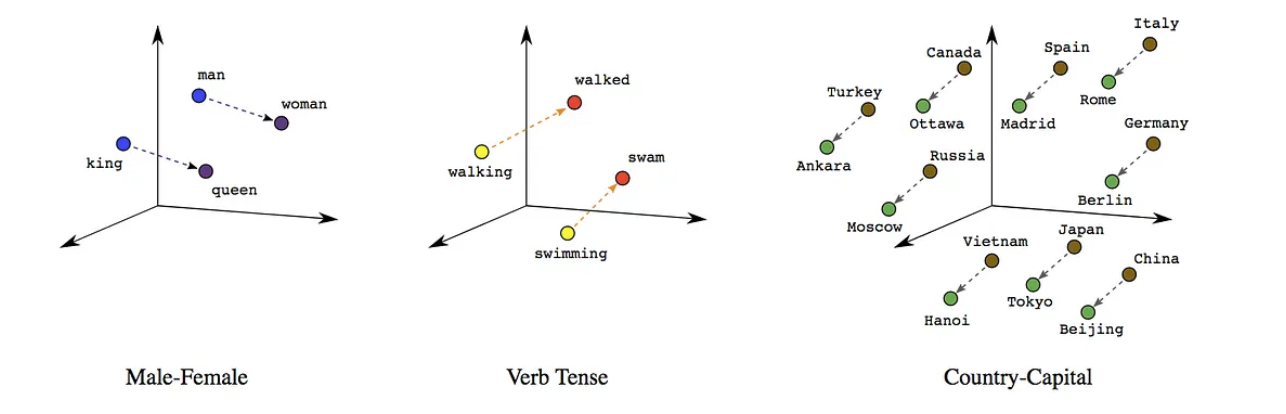

The way Word2Vec works is by transforming two different words into their own respective vectors, where the vectorization process is determined by the model's own algorithms. Once we have our two vectors, we can find the distance between them in order to see how similar the two words actually are. Shorter distances mean the two words are more similar whereas longer distances mean the two words are semantically different.

For example, in the above example, all of these paired words (as indicated by the arrow) would have a very small distance between them, as they have a similar context. King and queen have very similar contexts and in a similar fashion, Italy and Rome are also quite alike.

For our purposes, we can use it to compare a word from the our input and another word from a recipe name and see which recipe name in our dataset closely matches our input. However, we have multiple words that we need to compare. Since Word2Vec can only compare single words with one another, we need to use another technique. Here comes Doc2Vec.

Doc2Vec excels at generating document-level embeddings and capturing the overall context and semantics of entire documents or text segments. It provides a way to represent entire documents as continuous vectors. It can more or less do what Word2Vec does but on a larger scale.

## Model Design

Here is the general game plan for implementing word embeddings with Doc2Vec.

1. Convert our corpus (all the recipe names in our dataset) into TaggedDocument objects through a process called tokenization. In other words, we are converting each word in each recipe name into (Document ID, Word) pairs that we can use to train the Doc2Vec model.
2. Train the Doc2Vec model. Here's what the inner workings look like:
  * Doc2Vec employs a neural network architecture with two main components: a Paragraph Vector (DocVector) and Word Vectors.
  * The Paragraph Vector represents the entire document and is learned during training. Each document is assigned a unique vector.
  * The Word Vectors represent individual words and are initialized with pre-trained embeddings (e.g., Word2Vec embeddings) or learned from scratch.
  * The training objective is to learn the Paragraph Vector (DocVector) for each document so that it can accurately predict words within that document.
  * This is done by minimizing the negative log-likelihood of the target word given the context words (document and neighboring words). The model adjusts the DocVector and Word Vectors to maximize the likelihood of predicting context words accurately.
  * After training, the Doc2Vec model can be used for inference, where it takes a new document or text passage and converts it into a fixed-length vector (DocVector).
  * During inference, the Word Vectors are frozen (not updated), and the model infers the DocVector for the input document.
3. Now that we have our trained model all ready, we can use cosine similarity scores to see how similar the vectorized version of the recipe names are to a vectorized version of our input text data.
4. Extract the top 10 most similar entries in the dataset.



## Model Training

Let's begin implementing our model. Some things to note:
* There are various parameters that our Doc2Vec model accepts:
  * vector_size: The dimensionality of the document vectors (in this case, 100 dimensions)
  * window: The maximum distance between the current and predicted word within a sentence
  * min_count: Ignores all words with total frequency lower than this
  * workers: The number of CPU cores to use for training
  epochs: The number of training iterations (in this case, 10 epochs)
* We reduce the value for alpha for each iteration because initially, larger steps can help the model converge quickly towards a minimum of the loss function. However, as training progresses, it's important to reduce the learning rate to make smaller and more precise updates, which helps fine-tune the model and improve convergence stability.
* We are using the 'Cleaned_Image_Name' column instead of the 'Title' column because it contains more information about the recipe itself, so we would have more information to train the model on.


In [ ]:
import time
#at alpha .001 takes around 2 minutes to train
start_time = time.time()
# Create TaggedDocument objects from your text data
tagged_data = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(df_recipes['Cleaned_Image_Name'])]

# Initialize the Doc2vec model
doc2vec_model = Doc2Vec(vector_size=100, window=3, min_count=2, workers=4, epochs=10)

# Establishes the vocabulary domain using the tagged document objects
doc2vec_model.build_vocab(tagged_data)

# Train the Doc2Vec model for 10 epochs
for epoch in range(20):
    doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
    doc2vec_model.alpha -= 0.0001
    doc2vec_model.min_alpha = doc2vec_model.alpha
end_time = time.time()
total_time = end_time - start_time
print(f"Total training time was {total_time}")
# Save the model so it can be used.
doc2vec_model.save('d2v_recipe_names.model')

Total training time was 193.2359321117401


In [ ]:
# Load the trained Doc2Vec model from above
model = Doc2Vec.load('d2v_recipe_names.model')

#accuracy drops significantly when the word is lowercased

# Declare some user input (in the full project, this is the result we get from our CNN)
input_phrase = "Beignets"

# Generate an embedding for the input text data
input_phrase_embedding = model.infer_vector(input_phrase.split())

# Similarities will store cosine similarity with recipe name/ indices
similarities = []

# Iterate through the recipe names in the DataFrame
for index, row in df_recipes.iterrows():
    if isinstance(row['Title'], str):
    # Generate an embedding for the current recipe name
      recipe_name_embedding = model.infer_vector(row['Title'].split())

      # Calculate cosine similarity
      similarity_score = cosine_similarity([input_phrase_embedding],
                                           [recipe_name_embedding])[0][0]

      # Store the similarity score and DataFrame index
      similarities.append((index, similarity_score))

# Sort the recipe names by similarity scores in descending order
similarities.sort(key=lambda x: x[1], reverse=True)

# Get the top 10 most similar recipe names
top_10_similar_recipe_names = [(df_recipes.at[index, 'Title'], similarity_score)
 for index, similarity_score in similarities[:10]]

 # Print the top 10 most similar recipe names and their similarity scores
for recipe_name, similarity_score in top_10_similar_recipe_names:
    print(f"Recipe Name: {recipe_name}")
    print(f"Similarity Score: {similarity_score}")
    print(f"")
    print()

Recipe Name: Orange-Scented Beignets
Similarity Score: 0.9369337558746338


Recipe Name: Beignets
Similarity Score: 0.8897064924240112


Recipe Name: Coconut Shrimp Beignets with Pepper Jelly Sauce
Similarity Score: 0.688799262046814


Recipe Name: Chicken, Mushroom, and Bok Choy Kebabs
Similarity Score: 0.6551530361175537


Recipe Name: Big Easy Pumpkin Beignets
Similarity Score: 0.6550118923187256


Recipe Name: Beurre Blanc
Similarity Score: 0.6429033279418945


Recipe Name: Golden Beet Carpaccio
Similarity Score: 0.6422628164291382


Recipe Name: Speedy Gazpacho
Similarity Score: 0.6262108683586121


Recipe Name: Shrimp Boil
Similarity Score: 0.6223973035812378


Recipe Name: Brussels Sprout Slaw
Similarity Score: 0.6223753094673157




## Model Validation

Since our input can vary so much and we don't have a proper training set of inputs to use for cross-validation, we have had some difficulty finding out a proper validation method except for the eyeball test. But based on that, we can see that the 10 recipes we are getting all have some sort of apple component to them, with the similarity score of each of them consistently being between 86% and 93%. We encourage you to try out other inputs and see how the model performs!

In [ ]:
od.download(
    "https://www.kaggle.com/competitions/ifood-2019-fgvc6/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: thomaspanyasrivinit1
Your Kaggle Key: ··········


100%|██████████| 2.84G/2.84G [00:34<00:00, 87.8MB/s]



Extracting archive ./ifood-2019-fgvc6/ifood-2019-fgvc6.zip to ./ifood-2019-fgvc6


In [ ]:
df_class_list = pd.read_csv("/content/ifood-2019-fgvc6/class_list.txt", header=None)
df_class_list.rename(columns={0: 'Recipe Class'}, inplace=True)
df_class_list['Recipe Class'] = df_class_list['Recipe Class'].apply(lambda x: x.split(' ', 1)[1] if isinstance(x, str) else x)

listdf = df_class_list['Recipe Class'].values.tolist()



clean_list = [item.replace("_", " ") for item in listdf]

sc_list = [item.title() for item in clean_list]

print(sc_list)

#static list
short = ["pizza", "apple pie", "cupcake", "chow mein",
             "tiramisu",]
test_list = ["macaron", "beignet", "cruller", "apple pie", "samosa",
             "tiramisu","tostada","moussaka","dumpling","sashimi","knish",
             "croquette","couscous","porridge","stuffed_cabbage","seaweed salad",
             "chow_mein","rigatoni","beef tartare","cannoli","foie gras","cupcake"]
cap_list = [item.title() for item in short]




['Macaron', 'Beignet', 'Cruller', 'Cockle Food', 'Samosa', 'Tiramisu', 'Tostada', 'Moussaka', 'Dumpling', 'Sashimi', 'Knish', 'Croquette', 'Couscous', 'Porridge', 'Stuffed Cabbage', 'Seaweed Salad', 'Chow Mein', 'Rigatoni', 'Beef Tartare', 'Cannoli', 'Foie Gras', 'Cupcake', 'Osso Buco', 'Pad Thai', 'Poutine', 'Ramen', 'Pulled Pork Sandwich', 'Bibimbap', 'Chicken Kiev', 'Apple Pie', 'Risotto', 'Fruitcake', 'Chop Suey', 'Haggis', 'Scrambled Eggs', 'Frittata', 'Scampi', 'Sushi', 'Orzo', 'Fritter', 'Nacho', 'Beef Stroganoff', 'Beef Wellington', 'Spring Roll', 'Savarin', 'Crayfish Food', 'Souffle', 'Adobo', 'Streusel', 'Deviled Egg', 'Escargot', 'Club Sandwich', 'Carrot Cake', 'Falafel', 'Farfalle', 'Terrine', 'Poached Egg', 'Gnocchi', 'Bubble And Squeak', 'Egg Roll', 'Caprese Salad', 'Sauerkraut', 'Creme Brulee', 'Pavlova', 'Fondue', 'Scallop', 'Jambalaya', 'Tempura', 'Chocolate Cake', 'Potpie', 'Spaghetti Bolognese', 'Sukiyaki', 'Applesauce', 'Baklava', 'Salisbury Steak', 'Linguine', 'Eda

In [ ]:
#make a scatter plot of the values

import numpy as np
import time
from sklearn.metrics.pairwise import cosine_similarity

# Assuming model is your loaded Doc2Vec model
# input_phrases is a list of 250 input phrases
input_phrases = short
total_time = 0

# Function to compute average cosine similarity for an input phrase
def average_cosine_similarity(input_phrase, model, top_n=10):
    global total_time
    start_time = time.time()
    input_phrase_embedding = model.infer_vector(input_phrase.split())

    # Assuming df_recipes is your dataframe with recipe names
    similarities = []
    for recipe_name in df_recipes['Title']:
        if isinstance(recipe_name, str):
            recipe_embedding = model.infer_vector(recipe_name.split())
            similarity = cosine_similarity([input_phrase_embedding], [recipe_embedding])[0][0]
            similarities.append(similarity)

    # Get the top N similarities and calculate the average
    top_similarities = sorted(similarities, reverse=True)[:top_n]
    end_time = time.time()
    total_time = total_time + (end_time - start_time)
    return np.mean(top_similarities)

# Calculate the average cosine similarity for each input phrase
average_similarities = [average_cosine_similarity(phrase, model) for phrase in input_phrases]

print(f"Overall Average Cosine Similarity: {np.mean(average_similarities)}")
print(f"Overall Average Execution Time: {total_time / 250} seconds")


KeyboardInterrupt: ignored

In [ ]:
import numpy as np
import numpy as np
from gensim.models import Doc2Vec
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def calculate_mean_similarity(input_phrase, model):
    # Generate an embedding for the input text data
    input_phrase_embedding = model.infer_vector(input_phrase.split())
    print(f"The current input_phrase is {input_phrase}")
    # Similarities will store cosine similarity with recipe name/indices
    similarities = []

    # Iterate through the recipe names in the DataFrame
    for index, row in df_recipes.iterrows():
        if isinstance(row['Title'], str):
            # Generate an embedding for the current recipe name
            recipe_name_embedding = model.infer_vector(row['Title'].split())

            # Calculate cosine similarity
            similarity_score = cosine_similarity([input_phrase_embedding],
                                                 [recipe_name_embedding])[0][0]

            # Store the similarity score, DataFrame index, and recipe name
            similarities.append((index, similarity_score, row["Title"]))

    # Filter similarities based on input phrase
    filtered_similarities = [(index, score, title) for index, score, title in similarities
                             if input_phrase.lower() in title.lower()]

    # Sort filtered similarities by similarity score in descending order
    filtered_similarities.sort(key=lambda x: x[1], reverse=True)

    # Get the top N most similar recipe names
    top_n_similar_recipe_names = [(df_recipes.at[index, 'Title'], similarity_score)
                                  for index, similarity_score, _ in filtered_similarities[:10]]

    # # Print the top N most similar recipe names and their similarity scores
    # for recipe_name, similarity_score in top_n_similar_recipe_names:
    #     print(f"Recipe Name: {recipe_name}")
    #     print(f"Similarity Score: {similarity_score}")
    #     print()

    # Calculate the mean of the filtered similarity scores
    mean_filtered_similarity = np.mean([score for _, score, _ in filtered_similarities])

    print("Mean Filtered Similarity Score:", mean_filtered_similarity)

    return mean_filtered_similarity

# Example usage:
# Load the trained Doc2Vec model
model = Doc2Vec.load('d2v_recipe_names.model')

# Assuming df_recipes is your DataFrame with recipe names
# and input_phrase is the user input
input_phrase = "Apple Pie"
input_phrases = sc_list

# Call the function to calculate the mean similarity
# mean_similarity = calculate_mean_similarity(input_phrase, model)

average_similarities = [calculate_mean_similarity(phrase, model) for phrase in input_phrases]
print(f"Overall Average Cosine Similarity: {np.mean(average_similarities)}")

The current input_phrase is Macaron
Mean Filtered Similarity Score: 0.08171788
The current input_phrase is Beignet
Mean Filtered Similarity Score: 0.0054025203
The current input_phrase is Cruller
Mean Filtered Similarity Score: 0.15699479
The current input_phrase is Cockle Food


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Samosa
Mean Filtered Similarity Score: 0.026826523
The current input_phrase is Tiramisu
Mean Filtered Similarity Score: 0.5829203
The current input_phrase is Tostada
Mean Filtered Similarity Score: -0.008668501
The current input_phrase is Moussaka
Mean Filtered Similarity Score: 0.71158063
The current input_phrase is Dumpling
Mean Filtered Similarity Score: 0.38958088
The current input_phrase is Sashimi
Mean Filtered Similarity Score: 0.07204108
The current input_phrase is Knish


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Croquette
Mean Filtered Similarity Score: 0.039719876
The current input_phrase is Couscous
Mean Filtered Similarity Score: 0.46429297
The current input_phrase is Porridge
Mean Filtered Similarity Score: 0.6135901
The current input_phrase is Stuffed Cabbage
Mean Filtered Similarity Score: 0.18668666
The current input_phrase is Seaweed Salad
Mean Filtered Similarity Score: 0.49802297
The current input_phrase is Chow Mein
Mean Filtered Similarity Score: 0.32943398
The current input_phrase is Rigatoni
Mean Filtered Similarity Score: 0.5235043
The current input_phrase is Beef Tartare


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Cannoli
Mean Filtered Similarity Score: 0.4162224
The current input_phrase is Foie Gras
Mean Filtered Similarity Score: 0.5708779
The current input_phrase is Cupcake
Mean Filtered Similarity Score: 0.42055756
The current input_phrase is Osso Buco
Mean Filtered Similarity Score: 0.5776298
The current input_phrase is Pad Thai
Mean Filtered Similarity Score: 0.7208541
The current input_phrase is Poutine


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Ramen
Mean Filtered Similarity Score: 0.58444226
The current input_phrase is Pulled Pork Sandwich
Mean Filtered Similarity Score: 0.58007246
The current input_phrase is Bibimbap
Mean Filtered Similarity Score: 0.71602726
The current input_phrase is Chicken Kiev


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Apple Pie
Mean Filtered Similarity Score: 0.6583086
The current input_phrase is Risotto
Mean Filtered Similarity Score: 0.5588469
The current input_phrase is Fruitcake
Mean Filtered Similarity Score: 0.4919018
The current input_phrase is Chop Suey


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Haggis


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Scrambled Eggs
Mean Filtered Similarity Score: 0.50096345
The current input_phrase is Frittata
Mean Filtered Similarity Score: 0.62891585
The current input_phrase is Scampi
Mean Filtered Similarity Score: 0.5110018
The current input_phrase is Sushi
Mean Filtered Similarity Score: 0.56471026
The current input_phrase is Orzo
Mean Filtered Similarity Score: 0.5388528
The current input_phrase is Fritter
Mean Filtered Similarity Score: -0.102013424
The current input_phrase is Nacho
Mean Filtered Similarity Score: 0.6015304
The current input_phrase is Beef Stroganoff
Mean Filtered Similarity Score: 0.92722845
The current input_phrase is Beef Wellington
Mean Filtered Similarity Score: 0.71840805
The current input_phrase is Spring Roll
Mean Filtered Similarity Score: 0.1814503
The current input_phrase is Savarin


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Crayfish Food


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Souffle
Mean Filtered Similarity Score: 0.4610804
The current input_phrase is Adobo
Mean Filtered Similarity Score: 0.55794156
The current input_phrase is Streusel
Mean Filtered Similarity Score: 0.59747213
The current input_phrase is Deviled Egg
Mean Filtered Similarity Score: 0.74086106
The current input_phrase is Escargot
Mean Filtered Similarity Score: -0.049614307
The current input_phrase is Club Sandwich
Mean Filtered Similarity Score: 0.12759794
The current input_phrase is Carrot Cake
Mean Filtered Similarity Score: 0.749347
The current input_phrase is Falafel
Mean Filtered Similarity Score: 0.5567163
The current input_phrase is Farfalle
Mean Filtered Similarity Score: 0.56078225
The current input_phrase is Terrine
Mean Filtered Similarity Score: 0.5268603
The current input_phrase is Poached Egg
Mean Filtered Similarity Score: 0.6595966
The current input_phrase is Gnocchi
Mean Filtered Similarity Score: 0.5285069
Th

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Pavlova
Mean Filtered Similarity Score: 0.43829757
The current input_phrase is Fondue
Mean Filtered Similarity Score: 0.6068334
The current input_phrase is Scallop
Mean Filtered Similarity Score: 0.41370806
The current input_phrase is Jambalaya
Mean Filtered Similarity Score: 0.49345553
The current input_phrase is Tempura
Mean Filtered Similarity Score: 0.41949874
The current input_phrase is Chocolate Cake
Mean Filtered Similarity Score: 0.5729948
The current input_phrase is Potpie
Mean Filtered Similarity Score: 0.6125146
The current input_phrase is Spaghetti Bolognese


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Sukiyaki


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Applesauce
Mean Filtered Similarity Score: 0.5019448
The current input_phrase is Baklava
Mean Filtered Similarity Score: 0.53361076
The current input_phrase is Salisbury Steak


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Linguine
Mean Filtered Similarity Score: 0.5756996
The current input_phrase is Edamame
Mean Filtered Similarity Score: 0.6222735
The current input_phrase is Coq Au Vin
Mean Filtered Similarity Score: 0.37486902
The current input_phrase is Tamale
Mean Filtered Similarity Score: 0.5197708
The current input_phrase is Macaroni And Cheese
Mean Filtered Similarity Score: 0.71119565
The current input_phrase is Kedgeree


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Garlic Bread
Mean Filtered Similarity Score: 0.6725953
The current input_phrase is Beet Salad
Mean Filtered Similarity Score: 0.70680183
The current input_phrase is Steak Tartare
Mean Filtered Similarity Score: 0.6164583
The current input_phrase is Vermicelli
Mean Filtered Similarity Score: 0.61969906
The current input_phrase is Pate
Mean Filtered Similarity Score: 0.43586287
The current input_phrase is Pancake
Mean Filtered Similarity Score: 0.37549475
The current input_phrase is Tetrazzini
Mean Filtered Similarity Score: 0.018562391
The current input_phrase is Onion Rings
Mean Filtered Similarity Score: 0.7112483
The current input_phrase is Red Velvet Cake
Mean Filtered Similarity Score: 0.33057112
The current input_phrase is Compote
Mean Filtered Similarity Score: 0.5628482
The current input_phrase is Lobster Food


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Chicken Curry
Mean Filtered Similarity Score: 0.8045422
The current input_phrase is Chicken Wing
Mean Filtered Similarity Score: 0.15965705
The current input_phrase is Caesar Salad
Mean Filtered Similarity Score: 0.70140034
The current input_phrase is Succotash
Mean Filtered Similarity Score: 0.6153415
The current input_phrase is Hummus
Mean Filtered Similarity Score: 0.6242798
The current input_phrase is Fish And Chips
Mean Filtered Similarity Score: 0.71628565
The current input_phrase is Lasagna
Mean Filtered Similarity Score: 0.5629853
The current input_phrase is Lutefisk


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Sloppy Joe
Mean Filtered Similarity Score: 0.7434548
The current input_phrase is Gingerbread
Mean Filtered Similarity Score: 0.6218852
The current input_phrase is Crab Cake
Mean Filtered Similarity Score: 0.3996733
The current input_phrase is Sauerbraten


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Peking Duck


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Guacamole
Mean Filtered Similarity Score: 0.56907463
The current input_phrase is Ham Sandwich


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Crumpet


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Taco
Mean Filtered Similarity Score: 0.3846928
The current input_phrase is Strawberry Shortcake
Mean Filtered Similarity Score: 0.8086898
The current input_phrase is Clam Chowder
Mean Filtered Similarity Score: 0.7760321
The current input_phrase is Cottage Pie


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Croque Madame
Mean Filtered Similarity Score: 0.40686864
The current input_phrase is French Onion Soup
Mean Filtered Similarity Score: 0.84218615
The current input_phrase is Beef Carpaccio


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Torte
Mean Filtered Similarity Score: 0.5684113
The current input_phrase is Poi
Mean Filtered Similarity Score: -0.043069847
The current input_phrase is Crab Food


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Bacon And Eggs
Mean Filtered Similarity Score: 0.5385081
The current input_phrase is Coffee Cake
Mean Filtered Similarity Score: 0.7124183
The current input_phrase is Custard
Mean Filtered Similarity Score: 0.4489015
The current input_phrase is Syllabub


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Pork Chop
Mean Filtered Similarity Score: 0.46393648
The current input_phrase is Fried Rice
Mean Filtered Similarity Score: 0.6196225
The current input_phrase is Boiled Egg
Mean Filtered Similarity Score: 0.49371734
The current input_phrase is Galantine


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Brisket
Mean Filtered Similarity Score: 0.5805764
The current input_phrase is Reuben
Mean Filtered Similarity Score: 0.6706168
The current input_phrase is Schnitzel
Mean Filtered Similarity Score: 0.6554184
The current input_phrase is Ambrosia Food


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Gyoza
Mean Filtered Similarity Score: -0.038593266
The current input_phrase is Jerky


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Ravioli
Mean Filtered Similarity Score: 0.46309662
The current input_phrase is Fried Calamari


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Spaghetti Carbonara
Mean Filtered Similarity Score: 0.50475687
The current input_phrase is Miso Soup
Mean Filtered Similarity Score: 0.7420543
The current input_phrase is Frozen Yogurt
Mean Filtered Similarity Score: 0.80961263
The current input_phrase is Wonton
Mean Filtered Similarity Score: 0.40008175
The current input_phrase is Panna Cotta
Mean Filtered Similarity Score: 0.6291312
The current input_phrase is French Toast
Mean Filtered Similarity Score: 0.7442141
The current input_phrase is Enchilada
Mean Filtered Similarity Score: 0.3950045
The current input_phrase is Ceviche
Mean Filtered Similarity Score: 0.61571854
The current input_phrase is Fettuccine
Mean Filtered Similarity Score: 0.57521623
The current input_phrase is Chili
Mean Filtered Similarity Score: 0.67785233
The current input_phrase is Flan
Mean Filtered Similarity Score: 0.511279
The current input_phrase is Kabob


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Sponge Cake
Mean Filtered Similarity Score: 0.6043656
The current input_phrase is Casserole
Mean Filtered Similarity Score: 0.59492236
The current input_phrase is Paella
Mean Filtered Similarity Score: 0.5193449
The current input_phrase is Blancmange
Mean Filtered Similarity Score: 0.07098623
The current input_phrase is Bruschetta
Mean Filtered Similarity Score: 0.5992861
The current input_phrase is Tortellini
Mean Filtered Similarity Score: 0.4937032
The current input_phrase is Grilled Salmon
Mean Filtered Similarity Score: 0.5865902
The current input_phrase is French Fries
Mean Filtered Similarity Score: 0.82282287
The current input_phrase is Shrimp And Grits
Mean Filtered Similarity Score: 0.74640507
The current input_phrase is Churro
Mean Filtered Similarity Score: 0.06298435
The current input_phrase is Donut
Mean Filtered Similarity Score: 0.599295
The current input_phrase is Meat Loaf Food


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Meatball
Mean Filtered Similarity Score: 0.39692533
The current input_phrase is Scrapple


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Strudel
Mean Filtered Similarity Score: 0.518404
The current input_phrase is Coconut Cake
Mean Filtered Similarity Score: 0.74469334
The current input_phrase is Marble Cake
Mean Filtered Similarity Score: 0.81975543
The current input_phrase is Filet Mignon
Mean Filtered Similarity Score: 0.6168199
The current input_phrase is Hamburger
Mean Filtered Similarity Score: 0.5689022
The current input_phrase is Fried Egg
Mean Filtered Similarity Score: 0.5011296
The current input_phrase is Tuna Tartare


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Penne
Mean Filtered Similarity Score: 0.5666667
The current input_phrase is Eggs Benedict
Mean Filtered Similarity Score: 0.8175301
The current input_phrase is Bread Pudding
Mean Filtered Similarity Score: 0.5283877
The current input_phrase is Takoyaki


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Tenderloin
Mean Filtered Similarity Score: 0.6022885
The current input_phrase is Chocolate Mousse
Mean Filtered Similarity Score: 0.58761615
The current input_phrase is Baked Alaska
Mean Filtered Similarity Score: 0.8208091
The current input_phrase is Hot Dog
Mean Filtered Similarity Score: 0.6386292
The current input_phrase is Confit
Mean Filtered Similarity Score: 0.5806259
The current input_phrase is Ham And Eggs


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Biryani


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Greek Salad
Mean Filtered Similarity Score: 0.68454933
The current input_phrase is Huevos Rancheros
Mean Filtered Similarity Score: 0.79726183
The current input_phrase is Tagliatelle
Mean Filtered Similarity Score: 0.56722647
The current input_phrase is Stuffed Peppers
Mean Filtered Similarity Score: 0.75298434
The current input_phrase is Cannelloni
Mean Filtered Similarity Score: 0.478599
The current input_phrase is Pizza
Mean Filtered Similarity Score: 0.69730026
The current input_phrase is Sausage Roll
Mean Filtered Similarity Score: 0.24859436
The current input_phrase is Chicken Quesadilla


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Hot And Sour Soup


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Prime Rib
Mean Filtered Similarity Score: 0.5346775
The current input_phrase is Cheesecake
Mean Filtered Similarity Score: 0.6663741
The current input_phrase is Limpet Food


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Ziti
Mean Filtered Similarity Score: 0.6145982
The current input_phrase is Mussel
Mean Filtered Similarity Score: 0.42370996
The current input_phrase is Manicotti
Mean Filtered Similarity Score: 0.9053149
The current input_phrase is Ice Cream
Mean Filtered Similarity Score: 0.51063275
The current input_phrase is Waffle
Mean Filtered Similarity Score: 0.4128223
The current input_phrase is Oyster
Mean Filtered Similarity Score: 0.39408886
The current input_phrase is Omelette
Mean Filtered Similarity Score: 0.71362853
The current input_phrase is Clam Food


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Burrito
Mean Filtered Similarity Score: 0.47834787
The current input_phrase is Roulade
Mean Filtered Similarity Score: 0.5165141
The current input_phrase is Lobster Bisque


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Grilled Cheese Sandwich
Mean Filtered Similarity Score: 0.6027091
The current input_phrase is Gyro
Mean Filtered Similarity Score: 0.0329904
The current input_phrase is Pound Cake
Mean Filtered Similarity Score: 0.5325359
The current input_phrase is Pho
Mean Filtered Similarity Score: 0.45081323
The current input_phrase is Lobster Roll Sandwich


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Baby Back Rib
Mean Filtered Similarity Score: 0.087887146
The current input_phrase is Tapenade
Mean Filtered Similarity Score: 0.47707358
The current input_phrase is Pepper Steak
Mean Filtered Similarity Score: 0.6675398
The current input_phrase is Welsh Rarebit


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Pilaf
Mean Filtered Similarity Score: 0.5164919
The current input_phrase is Dolmas


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Coquilles Saint Jacques


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Veal Cordon Bleu


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Shirred Egg
Mean Filtered Similarity Score: 0.45036352
The current input_phrase is Barbecued Wing


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Lobster Thermidor


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Steak Au Poivre
Mean Filtered Similarity Score: 0.77197725
The current input_phrase is Huitre


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Chiffon Cake
Mean Filtered Similarity Score: 0.61083186
The current input_phrase is Profiterole
Mean Filtered Similarity Score: -0.034995083
The current input_phrase is Toad In The Hole


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Chicken Marengo


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Victoria Sandwich


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Tamale Pie
Mean Filtered Similarity Score: 0.68883264
The current input_phrase is Boston Cream Pie


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Fish Stick
Mean Filtered Similarity Score: 0.39720953
The current input_phrase is Crumb Cake
Mean Filtered Similarity Score: 0.6937857
The current input_phrase is Chicken Provencale


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Vol Au Vent


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Entrecote


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Carbonnade Flamande


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Bacon Lettuce Tomato Sandwich


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Scotch Egg
Mean Filtered Similarity Score: 0.8049885
The current input_phrase is Pirogi


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Peach Melba
Mean Filtered Similarity Score: 0.89705163
The current input_phrase is Upside Down Cake
Mean Filtered Similarity Score: 0.697907
The current input_phrase is Applesauce Cake


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Rugulah


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Rock Cake


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Barbecued Spareribs


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Beef Bourguignonne
Mean Filtered Similarity Score: 0.8126983
The current input_phrase is Rissole


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Mostaccioli


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Apple Turnover
Mean Filtered Similarity Score: 0.44774026
The current input_phrase is Matzo Ball
Mean Filtered Similarity Score: 0.5536658
The current input_phrase is Chicken Cordon Bleu
Mean Filtered Similarity Score: 0.41715962
The current input_phrase is Eccles Cake


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Moo Goo Gai Pan


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean Filtered Similarity Score: nan
The current input_phrase is Buffalo Wing
Mean Filtered Similarity Score: 0.7931347
The current input_phrase is Stuffed Tomato
Mean Filtered Similarity Score: 0.52458197
Overall Average Cosine Similarity: nan


In [ ]:
print(average_similarities)
file_path = '/content/output.txt'

# Open the file in write mode ('w')
with open(file_path, 'w') as file:
    # Write each value to a new line in the file after converting to string
    for value in average_similarities:
        file.write(str(value) + '\n')

print(f"Values have been written to {file_path}")

[0.08171788, 0.0054025203, 0.15699479, nan, 0.026826523, 0.5829203, -0.008668501, 0.71158063, 0.38958088, 0.07204108, nan, 0.039719876, 0.46429297, 0.6135901, 0.18668666, 0.49802297, 0.32943398, 0.5235043, nan, 0.4162224, 0.5708779, 0.42055756, 0.5776298, 0.7208541, nan, 0.58444226, 0.58007246, 0.71602726, nan, 0.6583086, 0.5588469, 0.4919018, nan, nan, 0.50096345, 0.62891585, 0.5110018, 0.56471026, 0.5388528, -0.102013424, 0.6015304, 0.92722845, 0.71840805, 0.1814503, nan, nan, 0.4610804, 0.55794156, 0.59747213, 0.74086106, -0.049614307, 0.12759794, 0.749347, 0.5567163, 0.56078225, 0.5268603, 0.6595966, 0.5285069, 0.6474942, 0.54894996, 0.6271614, 0.48776007, nan, 0.43829757, 0.6068334, 0.41370806, 0.49345553, 0.41949874, 0.5729948, 0.6125146, nan, nan, 0.5019448, 0.53361076, nan, 0.5756996, 0.6222735, 0.37486902, 0.5197708, 0.71119565, nan, 0.6725953, 0.70680183, 0.6164583, 0.61969906, 0.43586287, 0.37549475, 0.018562391, 0.7112483, 0.33057112, 0.5628482, nan, 0.8045422, 0.15965705, 

In [ ]:
import numpy as np

# Load the trained Doc2Vec model from above
model = Doc2Vec.load('d2v_recipe_names.model')

# Declare some user input (in the full project, this is the result we get from our CNN)
input_phrase = "Samosa"

# Generate an embedding for the input text data
input_phrase_embedding = model.infer_vector(input_phrase.split())

# Similarities will store cosine similarity with recipe name/ indices
similarities = []

# Iterate through the recipe names in the DataFrame
for index, row in df_recipes.iterrows():
    if isinstance(row['Title'], str):
    # Generate an embedding for the current recipe name
      recipe_name_embedding = model.infer_vector(row['Title'].split())

      # Calculate cosine similarity
      similarity_score = cosine_similarity([input_phrase_embedding],
                                           [recipe_name_embedding])[0][0]

      # Store the similarity score and DataFrame index
      similarities.append((index, similarity_score, row["Title"]))

filtered_similarities = []

for index, score, title in similarities:
    if input_phrase.lower() in title.lower():
        filtered_similarities.append((index, score, title))

print(filtered_similarities)
filtered_similarities.sort(key=lambda x: x[1], reverse=True)
print(filtered_similarities)

# Get the top 10 most similar recipe names
top_10_similar_recipe_names = [(df_recipes.at[index, 'Title'], similarity_score)
 for index, similarity_score, title in filtered_similarities[:10]]

 # Print the top 10 most similar recipe names and their similarity scores
for recipe_name, similarity_score in top_10_similar_recipe_names:
    print(f"Recipe Name: {recipe_name}")
    print(f"Similarity Score: {similarity_score}")
    print()


# Assuming filtered_similarities is the list containing filtered similarity scores
filtered_similarity_scores = [score for _, score, _ in filtered_similarities]

# Calculate the mean of the filtered similarity scores
mean_filtered_similarity = np.mean(filtered_similarity_scores)

print("Mean Filtered Similarity Score:", mean_filtered_similarity)



In [ ]:
filtered_similarities.sort(key=lambda x: x[1], reverse=True)
print(filtered_similarities)

# Get the top 10 most similar recipe names
top_10_similar_recipe_names = [(df_recipes.at[index, 'Title'], similarity_score)
 for index, similarity_score, title in filtered_similarities[:10]]

 # Print the top 10 most similar recipe names and their similarity scores
for recipe_name, similarity_score in top_10_similar_recipe_names:
    print(f"Recipe Name: {recipe_name}")
    print(f"Similarity Score: {similarity_score}")
    print()


# Assuming filtered_similarities is the list containing filtered similarity scores
filtered_similarity_scores = [score for _, score, _ in filtered_similarities]

# Calculate the mean of the filtered similarity scores
mean_filtered_similarity = np.mean(filtered_similarity_scores)

print("Mean Filtered Similarity Score:", mean_filtered_similarity)



Testing other Similarity Metrics

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from sklearn.metrics import jaccard_score, pairwise_distances
from scipy.stats import pearsonr, spearmanr

# Load the trained Doc2Vec model from above
model = Doc2Vec.load('d2v_recipe_names.model')

# Declare some user input (in the full project, this is the result we get from our CNN)
input_phrase = "Apple Pie"

# Generate an embedding for the input text data
input_phrase_embedding = model.infer_vector(input_phrase.split())

# Similarities will store various similarity scores with recipe name/indices
similarities = []

# Iterate through the recipe names in the DataFrame
for index, row in df_recipes.iterrows():
    if isinstance(row['Title'], str):
        # Generate an embedding for the current recipe name
        recipe_name_embedding = model.infer_vector(row['Title'].split())

        # Calculate various similarity metrics
        cosine_similarity_score = cosine_similarity([input_phrase_embedding], [recipe_name_embedding])[0][0]
        euclidean_distance = 1 / (1 + euclidean_distances([input_phrase_embedding], [recipe_name_embedding])[0][0])
        manhattan_distance = 1 / (1 + manhattan_distances([input_phrase_embedding], [recipe_name_embedding])[0][0])
        pearson_correlation, _ = pearsonr(input_phrase_embedding, recipe_name_embedding)
        spearman_correlation, _ = spearmanr(input_phrase_embedding, recipe_name_embedding)

        # Store the similarity scores and DataFrame index
        similarities.append((index, cosine_similarity_score, euclidean_distance,
                             manhattan_distance,
                             pearson_correlation, spearman_correlation, row["Title"]))

# Filter similarities based on whether the input phrase is in the recipe title
filtered_similarities = [(index, *scores, title) for index, *scores, title in similarities
                         if input_phrase.lower() in title.lower()]

# Sort the filtered similarities by cosine similarity scores in descending order
filtered_similarities.sort(key=lambda x: x[1], reverse=True)

# Print the filtered similarities
print("\nFiltered Similarities:")
for similarity in filtered_similarities:
    index, cosine_sim, euclidean_dist, manhattan_dist, pearson_corr, spearman_corr, title = similarity
    print(f"Index: {index}, Title: {title}")
    print(f"Cosine Similarity: {cosine_sim}")
    print(f"Euclidean Distance: {euclidean_dist}")
    print(f"Manhattan Distance: {manhattan_dist}")
    print(f"Pearson Correlation: {pearson_corr}")
    print(f"Spearman Correlation: {spearman_corr}")
    print()


# Conclusions

In conclusion, we hope participants got a better understanding on both Word2Vec and Doc2Vec, and how word embedding techniques tend to work. While our Doc2Vec model is not completely finished yet, we were able to get decent results in terms of the recipes outputted and the similarity scores between them. Similarly, the Word2Vec models using the Shakespeare dataset also yielded reasonable results with high similarity scores.

#Future Work

Our next steps for the project will be to increase the cosine similarity scores of our Doc2Vec model by further tuning the model's hyperparameters. At that point, we will try to explore better metrics of evaluating how well our model performs, whether it be by having a cosine similarity threshold or by using something like a Relative Norm Distance score. Additionally, for the purposes of the tutorial, we wanted to present the top 10 most similar recipes in an easy-to-understand format. However, for the final project, we would have to present each recipe's respective information as well and reformat everything so that it looks put together.

Looking beyond word embeddings, we will also have to use our other dataset to create a convolution neural network that takes in an image and produces a general food category, that will serve as the input for our Doc2Vec model.

# References

* Adam Conner-Simons | Rachel Gordon | CSAIL. (n.d.). Artificial Intelligence suggests recipes based on food photos. MIT News | Massachusetts Institute of Technology. https://news.mit.edu/2017/artificial-intelligence-suggests-recipes-based-on-food-photos-0720
* Hall, B. (2021, December 15). Using AI to identify ingredients and suggest recipes. Medium. https://medium.com/@brh373/using-ai-to-identify-ingredients-and-suggest-recipes-95482e2aca7d
* Inverse cooking: Recipe generation from food images - meta research. Meta Research. (n.d.). https://research.facebook.com/publications/inverse-cooking-recipe-generation-from-food-images/
* Singh, K. R. (n.d.). Social media has influenced and revolutionised food industry through virtual food communities, debating communities and networks XII. Debating Communities and Networks XII. https://networkconference.netstudies.org/2021/2021/04/30/social-media-has-influenced-and-revolutionised-food-industry-through-virtual-food-communities/  
* 262588213843476. (n.d.). Facebook cooking demo. Gist. https://gist.github.com/JonathanFly/33946a08080041e90e8360b25e263a4e#file-facebook-cooking-demo-ipynb



# Appendices

* 'Food Ingredients and Recipes Dataset with Images' Dataset: https://www.kaggle.com/code/mrmaheshchavan/foodclassification-resnet-vs-efficientnet-10epochs

<!-- If you're using code, data sets, examples, images or other material based on other people's work, acknowledge it here. This includes parts created with the help of generative AI tools, such as ChatGPT, Google Bard, or Microsoft Copilot. For images and similar material, you should also include a reference anchor or a link to the original.  -->